# Apple Mobility Trend Analysis
### **Author**: Nishanth Shyam

**DISCLAIMER**: Due to the data changing daily, some of the text (majority written on 28th April 2020) will appear out of sync with the graph and underlying data and will not necessarily reflect the daily changes to the data. This was started as a personal project combining the COVID-19 data and the Apple Mobility Trends data.

In this notebook, I will be using the data available from: https://www.apple.com/covid19/mobility. I'll be focusing on UK cities but will also compare other major countries and cities to see if there are any trends which are common amongst them.

In [1]:
# Install packages
import pandas
import matplotlib.pyplot as plt

# Read the data file
url = 'https://raw.githubusercontent.com/nshyam97/Apple-Mobility-Trends-Data/master/applemobility.csv'
mobility_data = pandas.read_csv(url, error_bad_lines=False)

Let's look at the data from the file to get a gauge as to the format and what data we have to work with and can compare.

In [2]:
mobility_data.head()

,geo_type,region,transportation_type,alternative_name,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,...,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15
0,country/region,Albania,driving,NaN,100.0,95.30,101.43,97.20,103.55,112.67,...,43.11,46.13,45.78,41.59,45.39,NaN,NaN,49.19,50.20,48.30
1,country/region,Albania,walking,NaN,100.0,100.68,98.93,98.46,100.85,100.13,...,52.84,52.37,48.10,44.86,68.87,NaN,NaN,61.79,56.46,54.41
2,country/region,Argentina,driving,NaN,100.0,97.07,102.45,111.21,118.45,124.01,...,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34
3,country/region,Argentina,walking,NaN,100.0,95.11,101.37,112.67,116.72,114.14,...,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63
4,country/region,Australia,driving,NaN,100.0,102.98,104.21,108.63,109.08,89.00,...,66.19,71.34,67.64,50.96,63.56,NaN,NaN,71.12,77.24,79.75


As we can see, we have a wide table with all the dates as separate columns. While this was probably the best way to show this data without having region and transportation type repeated multiple times, it doesn't make plotting this data or filtering through this data very useful. We will need to isolate the region and the transportation type and then transpose the date columns to make it possible to plot.

Firstly, we will check what regions and transportation types we have available?

In [3]:
mobility_data['transportation_type'].unique()

array(['driving', 'walking', 'transit'], dtype=object)

In [4]:
mobility_data['region'].unique()[:200]

array(['Albania', 'Argentina', 'Australia', 'Austria', 'Belgium',
       'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia',
       'Croatia', 'Czech Republic', 'Denmark', 'Egypt', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Ireland', 'Israel', 'Italy',
       'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Macao', 'Malaysia',
       'Mexico', 'Morocco', 'Netherlands', 'New Zealand', 'Norway',
       'Philippines', 'Poland', 'Portugal', 'Republic of Korea',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore',
       'Slovakia', 'Slovenia', 'South Africa', 'Spain', 'Sweden',
       'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'UK', 'Ukraine',
       'United Arab Emirates', 'United States', 'Uruguay', 'Vietnam',
       'Albuquerque', 'Amsterdam', 'Ann Arbor', 'Annapolis', 'Athens',
       'Atlanta', 'Auckland', 'Austin', 'Bakersfield', 'Baltimore',
       'Bangkok', 'Barcelona', '

In [5]:
mobility_data['region'].nunique()

799

We have 3 different transportation types but as we can see from the head of the table, some places do not have transit data. Looking at the region, we have a mix between countries and major cities and a total of 799 unique places. We will see what places actually have the transit data.

In [6]:
mobility_data[mobility_data['transportation_type'] == 'transit'].shape

(149, 128)

We have 149 out of a total 799 unique regions with transit data and they are a mix of countries and cities. A quick read through shows that only major countries and cities have transit data which makes sense as Apple would not have data for every country or city. This is just something to keep in mind going forward.

Now that we know what kind of data we are working with, we can start plotting and comparing different cities and countries using various transportation types. We will start with the UK cities which I have identified from this dataset. They are: London, Leeds, Birmingham, and Manchester.

Firstly, I will create a function that will take the city or country and the transportation type and create a separate data frame with the transposed date columns as separate rows and the corresponding values. This will allow us to plot them effectively.

In [7]:
# Function to transpose the data. Currently the date values are columns and so we need to make these rows
# to make plotting the data easier
def transpose_df(region_name, transportation):
    # First choose the region and transportation type to create the usable dataframe
    df = mobility_data[(mobility_data['region'] == region_name) &
                       (mobility_data['transportation_type'] == transportation)]
    # Drop the geo_type column as it isn't useful anymore
    df = df.drop(['geo_type', 'alternative_name'], axis=1)
    # Pivots the dataframe from a wide to a tall format. Move the Date and Values as separate rows and corresponding
    # columns.
    df_t = df.melt(['region', 'transportation_type'], var_name='Date', value_name='Value')
    # Convert date column to datetime column
    df_t.Date = pandas.to_datetime(df_t.Date, format='%Y-%m-%d')
    # Make date column the index column to allow for easier plotting
    df_t.set_index('Date', inplace=True)
    # Values are currently percentages with the first value being the baseline. To make it a change in
    # baseline mobility, minus all values by the first value.
    df_t.Value = df_t.Value - df_t.Value.iloc[0]
    # Round all the values to 2 decimal places
    df_t.Value = df_t.Value.round(2)
    # Return the finished dataframe, ready to plot
    return df_t

Now that we have this function, we can use this to create data frames for each of our UK cities so we can compare them graphically. We will be using the 'walking' transportation type initially to compare them all.

In [8]:
london = transpose_df('London', 'walking')
manchester = transpose_df('Manchester', 'walking')
birmingham = transpose_df('Birmingham - UK', 'walking')
leeds = transpose_df('Leeds', 'walking')

In [9]:
london.head()

,region,transportation_type,Value
Date,,,
2020-01-13,London,walking,0.00
2020-01-14,London,walking,8.89
2020-01-15,London,walking,16.84
2020-01-16,London,walking,18.82
2020-01-17,London,walking,32.18


As we can see from the London data frame example above, we now have a single data column with all the dates as rows and their corresponding values in the Value column. We also keep the region and transportation type columns which causes a lot of duplication but I felt it was better to keep them in there in case someone were to revisit this data frame later on in the code and wanted to know what it was showing. These columns can just as easily be removed as well.

Before we plot this data it is important to define what the values actually mean and why we subtracted every value by the first value. From the Apple Mobility Trends Report website, noted above, we see that the value corresponds to the "relative amount of directions requests per country/region or city compared to a baseline volume on January 13th 2020". If we look back at the initial view of the data when we first loaded it in, the baseline started at 100 and so by subtracting 100 from every value, we can display the graph as the percentage change from the baseline.

Now we can plot this data.

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


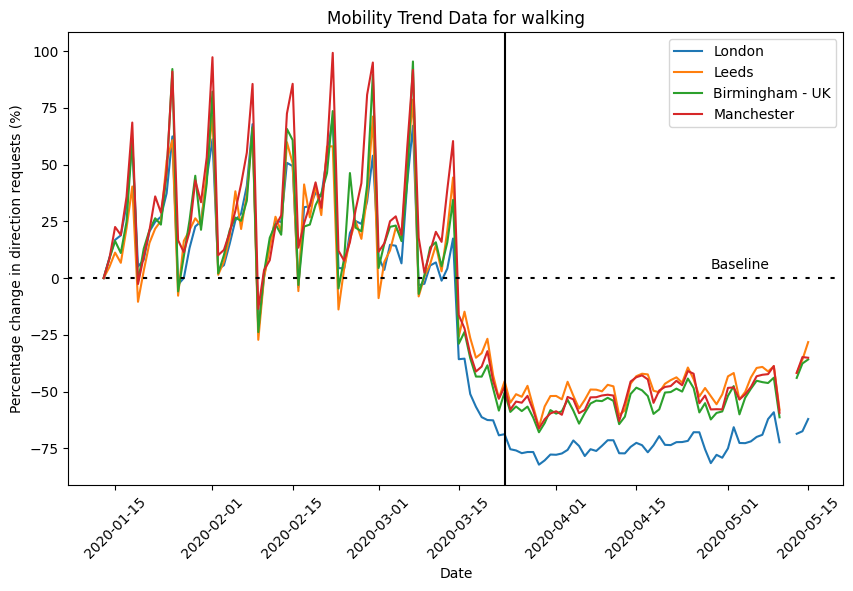

In [10]:
data = [london, leeds, birmingham, manchester]
fig=plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
# Iterate through every dataframe passed through this function
for frame in data:
    # Plot the date against the corresponding value
    plt.plot(frame.index, frame['Value'], label=frame['region'][0])
    
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Percentage change in direction requests (%)')
plt.title('Mobility Trend Data for ' + data[0]['transportation_type'][0])
# Plot vertical line for when the UK went into lockdown
plt.axvline(pandas.Timestamp('2020-03-23'), color='black')
plt.axhline(0, color='black', dashes=(2,4))
plt.text(pandas.Timestamp('2020-04-28'), 4, 'Baseline')
plt.legend()
plt.show()

On the graph, I have identified the date that the UK went into lockdown which was March 23rd 2020. In the run up to the lockdown, we can see that there is a pattern of increases and decreases in direction requests amongst all cities before the significant dip just before March 15th 2020.

If we look further into the data we can identify which days saw the sharp increases and which days showed the subsequent decreases. We can also look further into the abnormal dip seen between February 1st 2020 and February 15th 2020 which saw the direction requests dip further than normal.

Firstly, we will focus on the cyclical pattern before the significant change. We will look specifically at London and Birmingham as the 2 largest cities of the 4 available in the dataset.

In [11]:
london[london['Value'] > 50].sort_index()

,region,transportation_type,Value
Date,,,
2020-01-18,London,walking,60.29
2020-01-25,London,walking,62.41
2020-02-01,London,walking,61.17
2020-02-08,London,walking,67.80
2020-02-14,London,walking,50.77
2020-02-21,London,walking,53.95
2020-02-22,London,walking,70.22
2020-02-29,London,walking,53.92
2020-03-07,London,walking,67.10


In [12]:
birmingham[birmingham['Value'] > 50].sort_index()

,region,transportation_type,Value
Date,,,
2020-01-18,Birmingham - UK,walking,61.21
2020-01-25,Birmingham - UK,walking,92.10
2020-02-01,Birmingham - UK,walking,82.14
2020-02-08,Birmingham - UK,walking,66.45
2020-02-14,Birmingham - UK,walking,65.71
2020-02-15,Birmingham - UK,walking,60.79
2020-02-22,Birmingham - UK,walking,73.57
2020-02-29,Birmingham - UK,walking,89.70
2020-03-07,Birmingham - UK,walking,95.42


To find the days which we have spikes, I've taken a 50% increase as the threshold to look at. We can see that most of the dates for both cities line up and looking at the calendar we can see these dates are all Saturday's. This would make sense as it is the start of the weekend and people and families are most likely to be walking to new places and so will need directions. I would expect the days with the dips to be on a Monday as everyone returns to work but we can confirm this by looking at all the dates before the significant dip at around March 15th 2020 and percentages less than 0.

In [13]:
london[(london['Value'] <= 0) & (london.index < pandas.Timestamp('2020-03-15'))]

,region,transportation_type,Value
Date,,,
2020-01-13,London,walking,0.00
2020-01-26,London,walking,-2.84
2020-02-09,London,walking,-23.21
2020-02-16,London,walking,-3.97
2020-03-08,London,walking,-3.14
2020-03-09,London,walking,-2.50
2020-03-12,London,walking,-1.13


In [14]:
birmingham[(birmingham['Value'] <= 0) & (birmingham.index < pandas.Timestamp('2020-03-15'))]

,region,transportation_type,Value
Date,,,
2020-01-13,Birmingham - UK,walking,0.00
2020-01-19,Birmingham - UK,walking,-1.68
2020-01-26,Birmingham - UK,walking,-5.85
2020-02-09,Birmingham - UK,walking,-23.77
2020-02-16,Birmingham - UK,walking,-3.02
2020-02-23,Birmingham - UK,walking,-4.57
2020-03-08,Birmingham - UK,walking,-6.96


As we can see again, the dates generally line up with each other and they are all Sunday's which makes sense as people get ready for the working week ahead. We can also see that big dip happened on February 9th 2020 for both cities. 

Looking at headlines and major events that happened on the 9th February, we found that Storm Ciara had reached a peak and the Environment Agency had issued 186 flood alerts, 251 flood warnings, and 1 severe flood warning. Train companies had also issued "do not travel" warnings as well as a number of flights and ferries being cancelled. This is the most likely reason to have caused the significant dip as people were urged to stay at home due to the conditions of the storm. You can read more about Storm Ciara on this day [here](https://www.independent.co.uk/travel/news-and-advice/storm-ciara-travel-flights-trains-cancelled-uk-weather-latest-british-airways-easyjet-a9325456.html).

We can now look closer at the major dip on March 15th 2020. We want to look at the exact date that the dip happened so that we can see what was happening in the news during this time to see what could've caused this. We confirm that March 15th 2020 is the date we need to look at below.

In [15]:
london[(london.index >= pandas.Timestamp('2020-03-14')) & (london.index <= pandas.Timestamp('2020-03-16'))]

,region,transportation_type,Value
Date,,,
2020-03-14,London,walking,17.44
2020-03-15,London,walking,-35.72
2020-03-16,London,walking,-35.47


In [16]:
birmingham[(birmingham.index >= pandas.Timestamp('2020-03-14')) & (birmingham.index <= pandas.Timestamp('2020-03-16'))]

,region,transportation_type,Value
Date,,,
2020-03-14,Birmingham - UK,walking,34.46
2020-03-15,Birmingham - UK,walking,-28.91
2020-03-16,Birmingham - UK,walking,-23.71


Looking at news sources on March 15th, we can see that the UK was hit again by another storm, Storm Dennis. You can read more about Storm Dennis on this day [here](https://www.independent.co.uk/travel/news-and-advice/storm-dennis-easyjet-flight-cancellations-half-term-gatwick-airport-heathrow-british-airways-a9337211.html). The severity of this Storm caused the Met Office to issue multiple severe weather warnings, requiring people to stay at home where possible.

While this could be one of the reasons, the main news that happened on this day was the Secretary of State for Health and Social Care, Matt Hancock warned that Britons over the age of 70 will be told to stay at home in the coming weeks. Boris Johnson, then advised on Monday morning (March 16th) that non-essential travel should be avoided as well as contact with others. He suggested that people avoid pubs, clubs and restaurants and that pregnant women and over 70s should self isolate. [source](https://www.bbc.co.uk/news/uk-51895873)

On March 12th, the government had also advised that any people with symptoms such as a continuous cough and fever should self isolate for 7 days.

Knowing this, we can use COVID-19 related data to see how this compares to the mobility trend data that we have available to us.

I am going to use data from the John Hopkins github repository found [here](https://github.com/CSSEGISandData/COVID-19). I will be focusing on the UK deaths compared with the direction requests shown above.

In [17]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_data=pandas.read_csv(url, error_bad_lines=False)
corona_data.head()
    

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,104,106,109,115,120,122,127,132,136,153
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,476,483,488,494,502,507,515,522,529,536
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,46,47,47,48,48,48,48,49,49,49
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


As we can see, the format of this data is very similar to the format that we had before with the dates all set as columns and the countries and regions as separate rows. This means that we could use a modified version of the transpose_df function we created above to convert this table into a more usable format. First, let's check if the UK is present in this dataset.

In [18]:
corona_data[corona_data['Country/Region'] == 'United Kingdom']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
217,Bermuda,United Kingdom,32.3078,-64.7505,0,0,0,0,0,0,...,7,7,7,7,7,8,8,8,9,9
218,Cayman Islands,United Kingdom,19.3133,-81.2546,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
219,Channel Islands,United Kingdom,49.3723,-2.3644,0,0,0,0,0,0,...,40,40,41,41,41,41,42,43,43,43
220,Gibraltar,United Kingdom,36.1408,-5.3536,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,Isle of Man,United Kingdom,54.2361,-4.5481,0,0,0,0,0,0,...,23,23,23,23,23,23,23,23,23,24
222,Montserrat,United Kingdom,16.7425,-62.1874,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
223,NaN,United Kingdom,55.3781,-3.4360,0,0,0,0,0,0,...,30076,30615,31241,31587,31855,32065,32692,33186,33614,33998
248,Anguilla,United Kingdom,18.2206,-63.0686,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
249,British Virgin Islands,United Kingdom,18.4207,-64.6400,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
250,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


So we have the United Kingdom present but we also have a number of overseas territories as well, divided using the Province/State column. We want to focus on mainland UK and so we will just target the row with an NaN value in the Province/State column.

In [19]:
uk_row = corona_data[(corona_data['Country/Region'] == 'United Kingdom') & (corona_data['Province/State'].isna())]
uk_row

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
223,NaN,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,...,30076,30615,31241,31587,31855,32065,32692,33186,33614,33998


Now that we have the row that we need, we can use a modified function from the one I have created earlier to get the data into a usable format for plotting. One thing also to note is that the dates are in mm/dd/yy format as opposed to the YYYY-mm-dd format used above. We will need to fix this as well.

In [20]:
# Function to transpose the data. Currently the date values are columns and so we need to make these rows
# to make plotting the data easier
def transpose_corona_row(df):
    # Drop the province/state, Lat, and Long columns as they aren't useful anymore
    df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)
    # Pivots the dataframe from a wide to a tall format. Move the Date and Values as separate rows and corresponding
    # columns.
    df_t = df.melt(['Country/Region'], var_name='Date', value_name='Value')
    # Convert date column to datetime column
    df_t.Date = pandas.to_datetime(df_t.Date)
    # Make date column the index column to allow for easier plotting
    df_t.set_index('Date', inplace=True)
    # Return the finished dataframe, ready to plot
    return df_t

In [21]:
UK_deaths = transpose_corona_row(uk_row)
UK_deaths.head()

,Country/Region,Value
Date,,
2020-01-22,United Kingdom,0
2020-01-23,United Kingdom,0
2020-01-24,United Kingdom,0
2020-01-25,United Kingdom,0
2020-01-26,United Kingdom,0


Now that we have the data in a format that we are happy with, we can see that the data for corona virus dates are different to the dates provided by Apple in the mobility report. This is fine as we saw that the mobility data established a baseline before showing the big drop. That being said we can still plot both onto the same graph and see how things change as the number of deaths increases within the UK.

Instead of plotting each individual city, I will be plotting the UK as a whole.

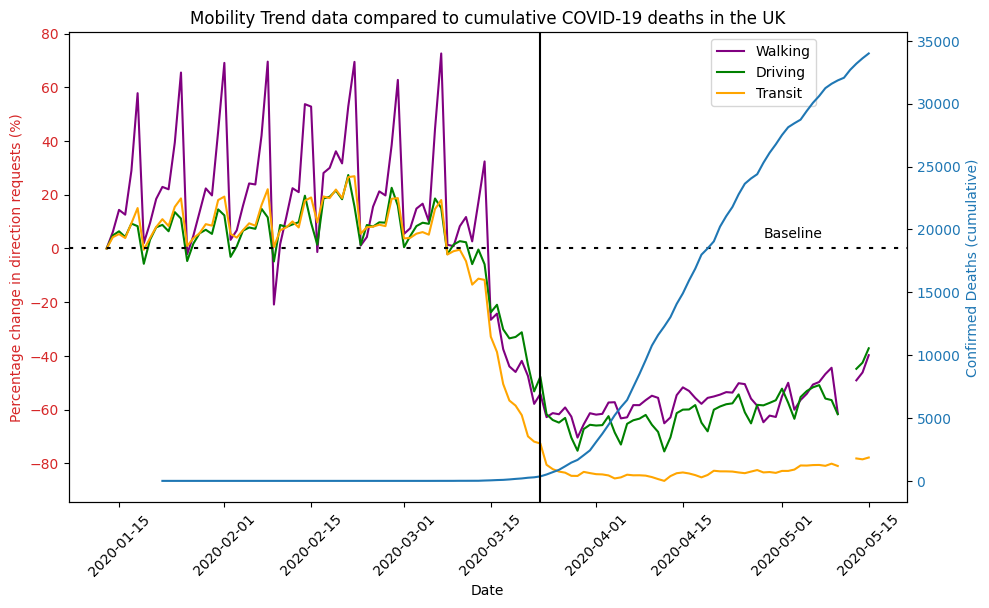

In [22]:
UK_walking = transpose_df('UK', 'walking')
UK_driving = transpose_df('UK', 'driving')
UK_transit = transpose_df('UK', 'transit')
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel('Percentage change in direction requests (%)', color=color)
ax1.plot(UK_walking.index, UK_walking['Value'], label='Walking', color='purple')
ax1.plot(UK_driving.index, UK_driving['Value'], label='Driving', color='green')
ax1.plot(UK_transit.index, UK_transit['Value'], label='Transit', color='orange')
ax1.legend(bbox_to_anchor=(0.9,1), loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', dashes=(2,4))
ax1.text(pandas.Timestamp('2020-04-28'), 4, 'Baseline')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed Deaths (cumulative)', color=color)  # we already handled the x-label with ax1
ax2.plot(UK_deaths.index, UK_deaths['Value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(pandas.Timestamp('2020-03-23'), color='black')
plt.title('Mobility Trend data compared to cumulative COVID-19 deaths in the UK')
plt.show()

We can see that the deaths in the UK were just starting to rise when the lockdown was put into force and then shortly after, the number of deaths increased exponentially. As you can see, we have more up-to-date data from the John Hopkins dataset than we do from the Apple mobility trends dataset but we can see that the reduction in mobility requests decreased dramatically before the lockdown but this did not have the effect that many government officials wanted. We have only seen the deaths and we know now that the incubation period for this virus varies between 1 and 14 days before severe symptoms start to show and possibly longer before death. A more interesting metric to compare mobility data with would be to use confirmed cases of the virus.

We will use the same source as before which is taken from the John Hopkins Github page linked above. The code used to clean and transpose the death data will be the exact same as the data is set up in a similar way.

In [23]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

corona_cases=pandas.read_csv(url, error_bad_lines=False)
corona_cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,832,842,850,856,868,872,876,880,898,916
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,751,752,752,754,755,755,758,760,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,36,36,43,43,45,45,45,45,48,48


In [24]:
uk_cases = corona_cases[(corona_cases['Country/Region'] == 'United Kingdom') & (corona_cases['Province/State'].isna())]
uk_cases

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20
223,NaN,United Kingdom,55.3781,-3.436,0,0,0,0,0,0,...,201101,206715,211364,215260,219183,223060,226463,229705,233151,236711


In [25]:
UK_cases = transpose_corona_row(uk_cases)
UK_cases.head()

,Country/Region,Value
Date,,
2020-01-22,United Kingdom,0
2020-01-23,United Kingdom,0
2020-01-24,United Kingdom,0
2020-01-25,United Kingdom,0
2020-01-26,United Kingdom,0


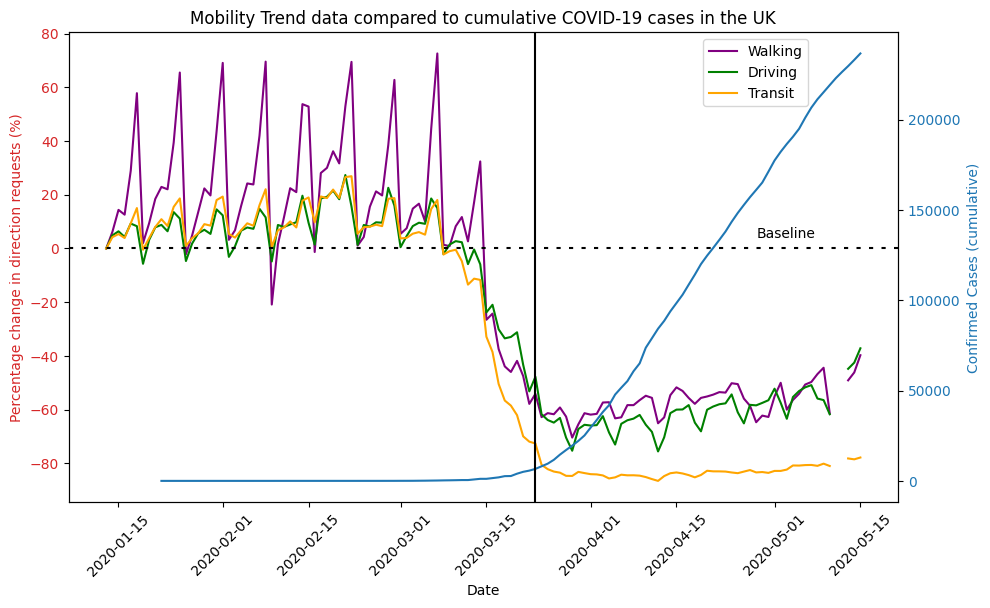

In [26]:
UK_walking = transpose_df('UK', 'walking')
UK_driving = transpose_df('UK', 'driving')
UK_transit = transpose_df('UK', 'transit')
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel('Percentage change in direction requests (%)', color=color)
ax1.plot(UK_walking.index, UK_walking['Value'], label='Walking', color='purple')
ax1.plot(UK_driving.index, UK_driving['Value'], label='Driving', color='green')
ax1.plot(UK_transit.index, UK_transit['Value'], label='Transit', color='orange')
ax1.legend(bbox_to_anchor=(0.9,1), loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', dashes=(2,4))
ax1.text(pandas.Timestamp('2020-04-28'), 4, 'Baseline')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed Cases (cumulative)', color=color)  # we already handled the x-label with ax1
ax2.plot(UK_cases.index, UK_cases['Value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(pandas.Timestamp('2020-03-23'), color='black')
plt.title('Mobility Trend data compared to cumulative COVID-19 cases in the UK')
plt.show()

As we can see, the confirmed cases follow a very similar trend to the number of deaths. However, if we look closer, the scale is very different to the one present in the deaths, where that scale topped out at just 20,000. If we change the scale of the confirmed cases to the same one as the deaths, we can compare them more accurately.

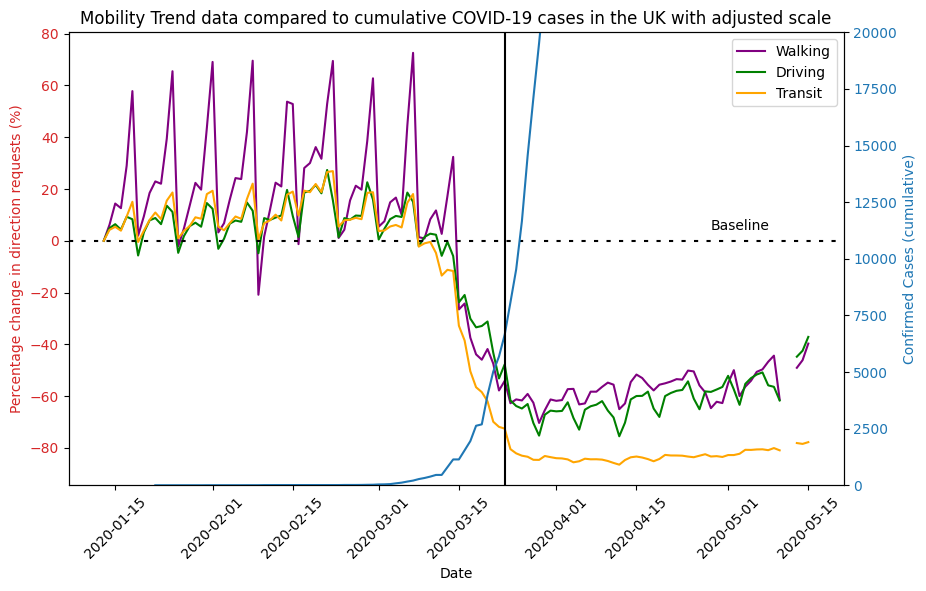

In [27]:
UK_walking = transpose_df('UK', 'walking')
UK_driving = transpose_df('UK', 'driving')
UK_transit = transpose_df('UK', 'transit')
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel('Percentage change in direction requests (%)', color=color)
ax1.plot(UK_walking.index, UK_walking['Value'], label='Walking', color='purple')
ax1.plot(UK_driving.index, UK_driving['Value'], label='Driving', color='green')
ax1.plot(UK_transit.index, UK_transit['Value'], label='Transit', color='orange')
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', dashes=(2,4))
ax1.text(pandas.Timestamp('2020-04-28'), 4, 'Baseline')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed Cases (cumulative)', color=color)  # we already handled the x-label with ax1
ax2.plot(UK_cases.index, UK_cases['Value'], color=color)
ax2.set_ylim(0, 20000)
ax2.tick_params(axis='y', labelcolor=color)

plt.axvline(pandas.Timestamp('2020-03-23'), color='black')
plt.title('Mobility Trend data compared to cumulative COVID-19 cases in the UK with adjusted scale')
plt.show()

Once we convert the y-axis scale to the same scale as the deaths, we can clearly see that the exponential rise in cases started about a week before the lockdown was announced. We hit around 7500 confirmed cases at the time of the lockdown announcement and the cases continued to rise at a rapid rate even after that. Even looking at the previous graph, the cases seem to continue to rise even to this date.

However, we are seeing the effects of the lockdown with Boris Johnson claiming that the UK is "turning the tide" [source](https://news.sky.com/story/coronavirus-boris-johnson-says-easing-lockdown-would-throw-away-effort-and-sacrifice-of-british-people-11979338) and a reduction in the daily deaths starting to show at time of writing (April 28th 2020).

In [28]:
UK_deaths_diff = UK_deaths.drop('Country/Region', axis=1) #Remove the country column
UK_deaths_diff = UK_deaths_diff.diff(axis=0) #Get the difference between each row to see daily totals
UK_deaths_diff.head()

,Value
Date,
2020-01-22,NaN
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


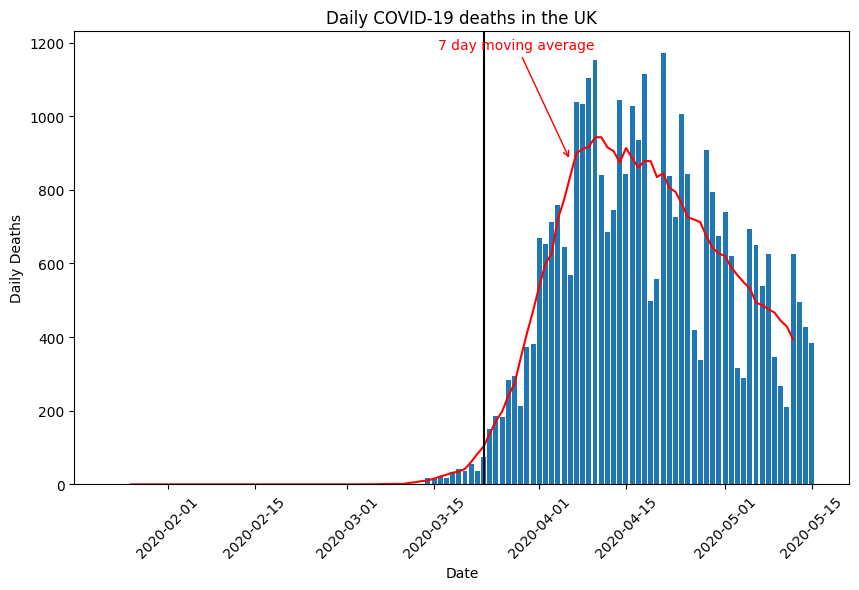

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

UK_deaths_diff = UK_deaths_diff.iloc[1:]

seasonal = seasonal_decompose(UK_deaths_diff['Value'], model='additive', period=7).trend
plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.bar(x=UK_deaths_diff.index, height=UK_deaths_diff['Value'])
plt.plot(UK_deaths_diff.index, seasonal, color='red')
plt.xlabel('Date')
plt.ylabel('Daily Deaths')
plt.xticks(rotation=45)
plt.axvline(pandas.Timestamp('2020-03-23'), color='black')
plt.annotate('7 day moving average', xy=(pandas.Timestamp('2020-04-06'), 880),  xycoords='data',
            xytext=(-95, 80), textcoords='offset points',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='red'), color='red')
plt.title('Daily COVID-19 deaths in the UK')
plt.show()

The above graph shows the daily deaths in the UK and we can see that after the lockdown was announced, there was an exponential increase in the number of deaths. We can see however that the daily deaths are trending down which is good news and shows that the UK is slowly coming out from the peak of the virus.

With the UK being one of the most affected countries in the world by the virus, it would be interesting to see how other countries coped with the rapid spread of this virus. Many people are praising South Korea's efforts to essentially "flatten the curve" without any restrictive lockdown. We can take a look at the mobility trend compared with the the one plotted for the UK and see what can be learnt from their efforts.

In [30]:
Korea_walking = transpose_df('Republic of Korea', 'walking')
Korea_driving = transpose_df('Republic of Korea', 'driving')
sk_row = corona_data[(corona_data['Country/Region'] == 'Korea, South') & (corona_data['Province/State'].isna())]
SK_deaths = transpose_corona_row(sk_row)
SK_deaths.head()

,Country/Region,Value
Date,,
2020-01-22,"Korea, South",0
2020-01-23,"Korea, South",0
2020-01-24,"Korea, South",0
2020-01-25,"Korea, South",0
2020-01-26,"Korea, South",0


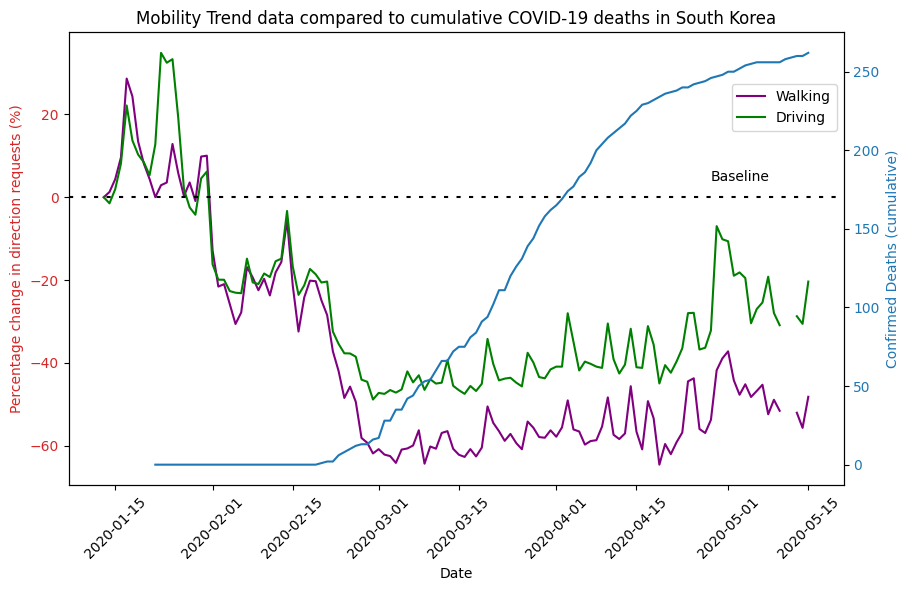

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_ylabel('Percentage change in direction requests (%)', color=color)
ax1.plot(Korea_walking.index, Korea_walking['Value'], label='Walking', color='purple')
ax1.plot(Korea_driving.index, Korea_driving['Value'], label='Driving', color='green')
ax1.legend(bbox_to_anchor=(1,0.9), loc='upper right')
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='black', dashes=(2,4))
ax1.text(pandas.Timestamp('2020-04-28'), 4, 'Baseline')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Confirmed Deaths (cumulative)', color=color)  # we already handled the x-label with ax1
ax2.plot(SK_deaths.index, SK_deaths['Value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Mobility Trend data compared to cumulative COVID-19 deaths in South Korea')
plt.show()

We can clearly see from the above plot that the mobility trends dropped significantly well before the first deaths were announced in the South Korea and continued to fall past the first deaths. This quick response by the South Koreans can not be stressed enough in terms of helping the country contain the number of deaths and cases and allowing the country to recover in a matter of weeks.

If the UK had taken a similar approach, we could see the number of deaths in the hundreds rather than the tens of thousands we are currently experiencing and that are still increasing.

While we continue to fight the coronavirus here in the UK, it is important for us to remember the lives that have been lost as well as the brave and strong NHS workers who continue to work long hours to take care of the sick. Without the support of the country, the task would be infinitely harder and I would like to express my condolences to those who have lost lives due to this virus. While this analysis reduces these deaths to just numbers, there is a life and story behind each one.